# Heartrate Variability - Kalume Lab

Reads in an EDF file then:
1. Plots all data channels
2. Finds peaks in respiratory and cardiac data
3. Finds relationship between breath peaks and cardiac peaks
4. (Future) Finds spectral density of EMG and Right/Left EEG
5. (Future) Calculate coherence in Right/Left EEG
6. (Future) Calculate coherence between ECG, EEG, and EMG



## User Input

In [1]:
dir_in = ''
#dir_in = r"C:\Users\haley\Dropbox\Code\Heartrate Variability\kalume_data"
#dir_in = r"D:\Dropbox\Code\Heartrate Variability\kalume_data"
file_in = r"Synchrony_EEG_ECG_RESP_K6527_HmzNdufsCrep_10_06_16_TISel.edf" 
amp_channels = [8,9,12,13] # Channel #s you want to analyze by amplitude
freq_channels = [10,11,14] # Channel #s you want to analyze by frequency
plot_start_time_mins = 0 # The time (in minutes) that you want to start analyzing the recording

# Values can be "all" (with quotation marks) or a number indicating the number of minutes 
plot_length_mins = "all"  # Length of Recording you wannt to analyze
template_start_time_mins = plot_start_time_mins  # Start time (in min) for defining the templates
template_search_length_mins = 0.05   # Length of recording for measuring the templates
sample_rate = 1000 # In Hz

# plot start can't be bigger plot_end
#template start needs fixing
# > 30s of stillness (in EMG)
# 50% overlap in FFT window of EMG

### Import Packages

In [2]:
import pyedflib
import os
import numpy as np
import matplotlib.pyplot as plt

### Function Definitions

In [22]:
def datapoints_to_minutes(datapoints):
    """ Takes either a list or an int and converts to minutes based on sample rate"""
    if type(datapoints) == list:
        minutes = []
        for dp in datapoints:
            mins = dp / (60 * sample_rate)
            minutes.append(mins)
    else:
        minutes = datapoints / (60 * sample_rate)
    return minutes

def datapoints_to_ms(datapoints):
    """ Takes either a list or an int and converts to milliseconds based on sample rate"""
    if type(datapoints) == list:
        milliseconds = []
        for dp in datapoints:
            ms = dp / sample_rate * 1000
            milliseconds.append(int(ms))
    else:
        milliseconds = datapoints/ sample_rate *1000
    return milliseconds

def minutes_to_datapoints (minutes):
    """ Takes either a list or a float and converts to datapoints (int) based on sample rate"""
    if type(minutes) == list:
        datapoints = []
        for mins in minutes:
            dp = mins * (60 * sample_rate)
            datapoints.append(int(dp))
    elif type(minutes) == float:
        datapoints = int(minutes * 60 * sample_rate)
    return datapoints

def get_plot_length (plot_length, sigbufs):
    """ Takes in a plot length in minutes (whole trace or a subsection of a trace)
        and returns it in datapoints"""
    if plot_length == 'all':
        plot_end_time = len(sigbufs[0,:])
    elif plot_length > len(sigbufs[0,:]):
        plot_end_time = len(sigbufs[0,:])
    elif plot_length < 0:
        print ("USER ERROR: Cannot plot a negative plot_length.")
    else:
        plot_end_time = plot_length * (60*sample_rate)
    return int(plot_end_time)

def get_edf (dir_in, file_in, file_open):
    """ Opens a Labchart EDF file from the specified file and directory"""
    if file_open == 0:
        file_name = os.path.join(dir_in, file_in)
        f = pyedflib.EdfReader(file_name)
        file_open = 1
    else:
        pass
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i,:] = f.readSignal(i)
    return signal_labels, sigbufs

def plot_all(signals, sigbufs,signal_labels, start, end):
    """ Takes lists of signals (channel-1 since python starts at 0), signal data (sigbufs),
        and signal labels and plots the data for each channel """
    fig_rows = len(signals)
    fig_cols = 1
    i = 0

    fig, [ax1,ax2,ax3,ax4,ax5,ax6,ax7] = plt.subplots(fig_rows, fig_cols, sharex=True, figsize = (10,15), dpi = 100)
    for i in range (0,len (signals)):
        signal = signals[i]
        time = list(range(0,len(sigbufs[0,start:end])))
        x = []
        for t in time:
            tmp = t/60000
            x.append(tmp)
        
        if i == 0: # Ch8
            y = sigbufs[signal,start:end]
            ax1.plot(x,y, lw = 1, color = "purple")
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            ax1.set_xlim (0, max(x))
            ax1.set_title ('Raw Respiration', loc = 'left')
            ax1.set_ylabel(signal_labels[i] + "(V) ", fontsize = 12)
            
        elif i == 1: # Ch9
            y = sigbufs[signal,start:end]
            ax2.plot(x,y, lw = 1, color = "darkgreen")
            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax2.set_title ('Filtered Respiration', loc = 'left')
        elif i == 2: # Ch10
            y = sigbufs[signal,start:end]
            ax3.plot(x,y, lw = 1, color = "orangered")
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax3.set_title ('EEG Left', loc = 'left')
        elif i == 3: # Ch11
            y = sigbufs[signal,start:end]
            ax4.plot(x,y, lw = 1, color = "blue")
            ax4.spines['top'].set_visible(False)
            ax4.spines['right'].set_visible(False)
            ax4.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax4.set_title ('EEG Right', loc = 'left')
        elif i == 4: # Ch12
            y = sigbufs[signal,start:end]
            ax5.plot(x,y, lw = 1, color = "green")
            ax5.spines['top'].set_visible(False)
            ax5.spines['right'].set_visible(False)
            ax5.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax5.set_title ('ECG', loc = 'left')
        elif i == 5: # Ch13
            y = sigbufs[signal,start:end]
            ax6.plot(x,y, lw = 1, color = "magenta")
            ax6.set_xlabel ("Time (min)", fontsize = 14)
            ax6.spines['top'].set_visible(False)
            ax6.spines['right'].set_visible(False)
            ax6.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax6.set_title ('EMG', loc = 'left')
        elif i == 6: # Ch14
            y = sigbufs[signal,start:end]
            ax7.plot(x,y, lw = 1, color = "magenta")
            ax7.set_xlabel ("Time (min)", fontsize = 14)
            ax7.spines['top'].set_visible(False)
            ax7.spines['right'].set_visible(False)
            ax7.set_ylabel(signal_labels[signals[i]] + "(BPM) ", fontsize = 12)
            ax7.set_title ('Respiration Rate', loc = 'left')
        elif i == 7: # Ch14
            y = sigbufs[signal,start:end] 
            ax8.plot(x,y, lw = 1, color = "blue")
            ax8.set_xlabel ("Time (min)", fontsize = 14)
            ax8.spines['top'].set_visible(False)
            ax8.spines['right'].set_visible(False)
            ax8.set_ylabel(signal_labels[signals[i]] + "(BPM) ", fontsize = 12)
            ax8.set_title ('Instantaneous Heart Rate', loc = 'left')
        elif i == 8: # Ch14
            y = sigbufs[signal,start:end]
            ax9.scatter(x,y, s = 1, marker = ".", color = "black")
            ax9.set_xlabel ("Time (min)", fontsize = 14)
            ax9.spines['top'].set_visible(False)
            ax9.spines['right'].set_visible(False)     
            ax9.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax9.set_title ('Synchrony', loc = 'left')
        i = i + 1
    fig.tight_layout()
    
def get_event(start, length, signal, sigbufs, threshold, baseline, plot_results):
    """ Searches the trace for the specified length (in datapoints) based on the user-specified
        threshold and baseline, with option to plot the results (True/False)"""
    events = []
    x = list(range(0,len(sigbufs[signal,start:length])))
    y = sigbufs[signal,start:length]
    if threshold == 0: # first pass will always assume 0 (ground) in template search
        threshold = ((max(y) - min(y))*.1) 
    
    event_peaks_x = []
    event_peaks_y = []
    event_widths = []
    event_half_widths = []
    baseline_x = []
    baseline_y = []
    peak_y = 0
    i = 0
    while i < len(x)-1:
        if y[i] < threshold and y[i] > -1*threshold:     
            while y[i] < threshold and i < len(x)-1:
                baseline_x.append (x[i])
                baseline_y.append (y[i])
                i = i + 1
        elif y[i] >= threshold:
            event_x = []
            event_y = []
            peak_x = 0
            peak_y = 0
            while y[i] > threshold and i < len(x)-1:
                event_x.append (x[i])
                event_y.append (y[i])
                if y[i] > peak_y:
                    peak_y = y[i]
                    peak_x = x[i]
                i = i + 1
            event_peaks_x.append(peak_x)
            event_peaks_y.append(peak_y-baseline)
            width = max(event_x)-min(event_x)
            event_widths.append(width)
            event = {'signal': signal, 'x': event_x, 'y': event_y, 'peak_y': peak_y, 'peak_x': peak_x, 'width': width}
            events.append (event)
        else: 
            i = i + 1
    baseline_mean = np.mean(baseline_y)
    baseline_std = np.std(baseline_y)
    
    
    if plot_results == True:
        fig, ax = plt.subplots(figsize = (10,3), dpi = 100)
        
        ax.plot(datapoints_to_minutes(x), sigbufs[signal,start:length], color = 'darkgray')
        ax.axhline(baseline_mean, color = "k", ls = "solid", label = "Baseline Mean = " + str(round(baseline_mean,3)))
        ax.axhline(baseline_mean + baseline_std, color='b', linestyle=':', label = "1*std = " + str(round(baseline_std,3)))
        ax.axhline(baseline_mean + 2*baseline_std, color='r', linestyle=':', label = "2*std = " + str(round(baseline_std*2,3)))
        ax.axhline(baseline_mean + 3*baseline_std, color='m', linestyle=':', label = "3*std = " + str(round(baseline_std*3,3)))
        ax.axhline(baseline_mean + 4*baseline_std, color='purple', linestyle=':', label = "4*std = " + str(round(baseline_std*4,3)))
        ax.axhline(baseline_mean - baseline_std , color='b', linestyle=':')
        ax.axhline(baseline_mean - 2*baseline_std, color='r', linestyle=':')
        ax.axhline(baseline_mean - 3*baseline_std, color='m', linestyle=':')
        ax.axhline(baseline_mean - 4*baseline_std, color='purple', linestyle=':')
        
        ax.set_xlim(datapoints_to_minutes(min(x)),datapoints_to_minutes(max(x)))    
        ax.spines['top'].set_visible (False)
        ax.spines['right'].set_visible (False)
        ax.set_title ('Channel ' + str(signal+1))
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1, 1))
        
        for event in events:
            x = event['peak_x']
            ax.plot(datapoints_to_minutes(x), event['peak_y']*.1 + event['peak_y'], ls=None, marker='*')
            
    return event_peaks_x, event_peaks_y, event_widths, event_half_widths, np.mean(baseline_y), np.std(baseline_y),events
            

def plot_events (events, event_xmax, event_ymax): # For each sognal, for each event, plot the event
    fig, ax = plt.subplots (figsize = (3,3), dpi = 100)
    ax.spines ['top'].set_visible (False)
    ax.spines ['right'].set_visible (False)
    x = list(range(event_xmax))
    y = [0] * event_xmax
    n = [0] * event_xmax
    y_mean = [np.nan] * event_xmax
    for event in events:
        i = 0
        for event_y in event['y']:
            if i < len(x):
                y[i] = y[i] + event_y
                n[i] = n[i] + 1
                i = i + 1
            else:
                i = 0
                y[i] = y[i] + event_y
                n[i] = n[i] + 1
                i = i + 1
        event_x = list(range(len(event['y'])))
        ax.plot (datapoints_to_ms(event_x), event['y'], color = 'gray', lw = 1)
    i = 0
    while i < len(x): 
        if np.isnan(y[i]) == False:
            y_mean[i] = y[i]/n[i]
        i = i + 1
         
    ax.plot (datapoints_to_ms(x), y_mean, color = 'black', lw = 4)
    ax.set_title('channel: ' + str(event['signal'] +1))
    ax.set_xlabel ("Time (ms)")
    ax.set_ylabel ("Voltage (V)")

    
def get_hrv (events_list):
    """The way Lab Chart is set up: 
        Channel 8 (event_list[0]) is unfiltered respiratory data)
        Channel 9 (event_list[1]) is 100Hz filtered respiratory data)
        Channel 12 (event_list[2] is cardiac data/EMG)
    """
    breath_events = events_list[1]
    heart_events = events_list[2]
    epochs = []
    i = 0 # Breath counter
    j = 0 # Heartbeat counter
    while i < len(breath_events)-1:
        heartbeats_x = []
        heartbeats_y = []
        heartbeats_width = []
        latencies = []
    
        if heart_events[j]['peak_x'] < breath_events[0]['peak_x']:
            j = j + 1
        else:
            while heart_events[j]['peak_x'] >= breath_events[i]['peak_x'] and heart_events[j]['peak_x'] < breath_events[i+1]['peak_x']:
                #print(heart_events[j]['peak_x'], breath_events[i]['peak_x'], breath_events[i+1]['peak_x'])
                heartbeats_x.append(heart_events[j]['peak_x'])
                heartbeats_y.append(heart_events[j]['peak_y'])                
                heartbeats_width.append(heart_events[j]['width'])
                latencies.append(heart_events[j]['peak_x']-breath_events[i]['peak_x'])
                j = j + 1
            epoch_length = breath_events[i]['peak_x'] - breath_events[i]['peak_x']
            epoch = {'breath_x': breath_events[i]['peak_x'], 'heartbeats_x': heartbeats_x, 'heartbeats_y': heartbeats_y, 
                     'breaths_width': breath_events[i]['width'], 'heartbeats_width': heartbeats_width, 
                     'epoch_length':epoch_length, 'latencies':latencies}
            epochs.append(epoch)
            i = i + 1
    return epochs

def plot_epochs (epochs):
    fig, ax = plt.subplots(figsize = (10,3), dpi = 100)
    colors = ['orange', "red", "purple", "blue", "teal", "green"]
    x = []
    y = []
    counter_x = 0
    counter_y = 0
    for epoch in epochs:
        counter_x = counter_x + 1
        x.append(counter_x)
        counter_y = 0
        y.append (counter_y)
        for latency in epoch['latencies']:
            counter_x = counter_x + 1
            x.append(counter_x)
            counter_y = counter_y + 1
            y.append (counter_y)
          
    metaplot = ax.plot(x[0:50], y[:50], marker = '*', ls = None)
    ax.set_xlabel('Breath Counts')
    ax.set_ylabel('Heartbeat per Breath')
    ax.set_title ("Heartbeats Per Breath")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(0, lw = 1, ls = ":")

### Default Values

In [6]:
file_open = 0   # 0 = EDF file hasn't been opened, 1 = it has been opened
threshold = 0
ground = 0
start = 0
plot_start_time_dp = int(plot_start_time_mins * 60 * sample_rate)
template_start_time_dp = int(template_start_time_mins * 60 * sample_rate)
template_search_length_dp = minutes_to_datapoints(template_search_length_mins)
template_end_time_dp = int (template_start_time_mins + template_search_length_dp)
all_channels = sorted(amp_channels + freq_channels)
all_signals = [chan - 1 for chan in all_channels]
amp_signals = [chan-1 for chan in amp_channels] 
freq_signals = [chan-1 for chan in freq_channels]

### Setup Signals

In [7]:
signal_labels, sigbufs = get_edf (dir_in, file_in, file_open) # reads in all signal labels
amp_labels = list(signal_labels[i] for i in amp_signals) # Labels for signals to be analyzed for amplitude
freq_labels = list(signal_labels[i] for i in freq_signals) # Labels for signals to be analyzed for frequency
plot_end_time_dp = int(plot_start_time_dp + get_plot_length (plot_length_mins, sigbufs)) # Gets plot length in datapoints

### Plot all signals

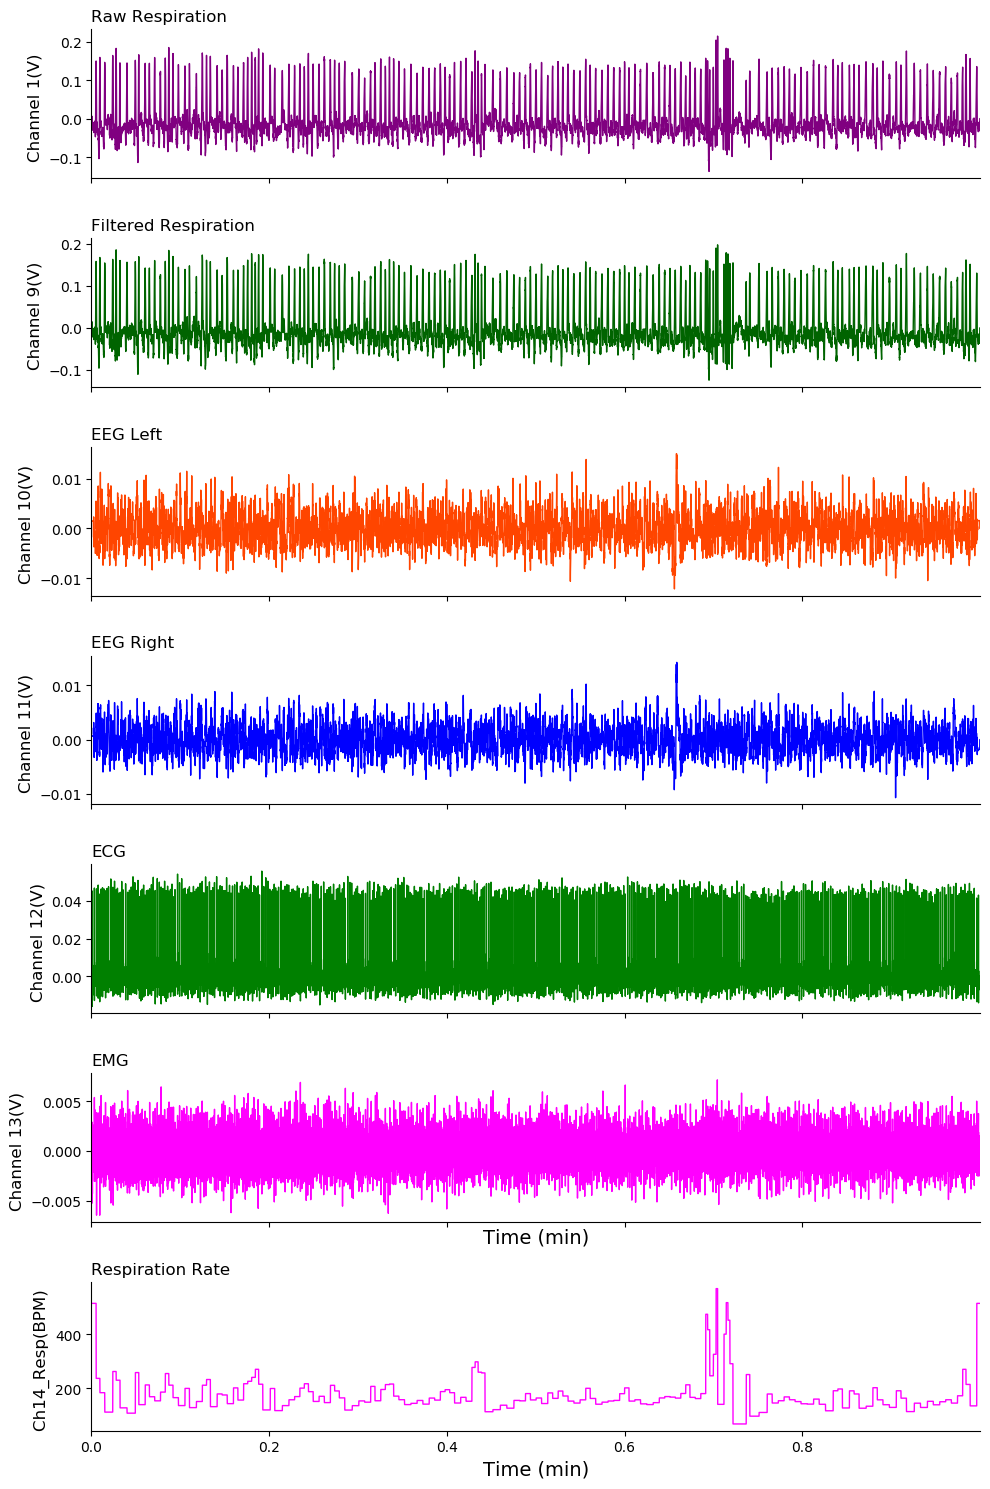

In [8]:
plot_all(all_signals, sigbufs,signal_labels,plot_start_time_dp, plot_end_time_dp)

### Define Templates

* Uses default threshold of 0 from baseline (also default 0) for the first pass
* Adjusts baseline by finding the moving average and standard deviation while excluding any outliers (> 2* the  std dev)
* Saves excluded data as templates for events
* (Optional) Plot the data with putative events marked

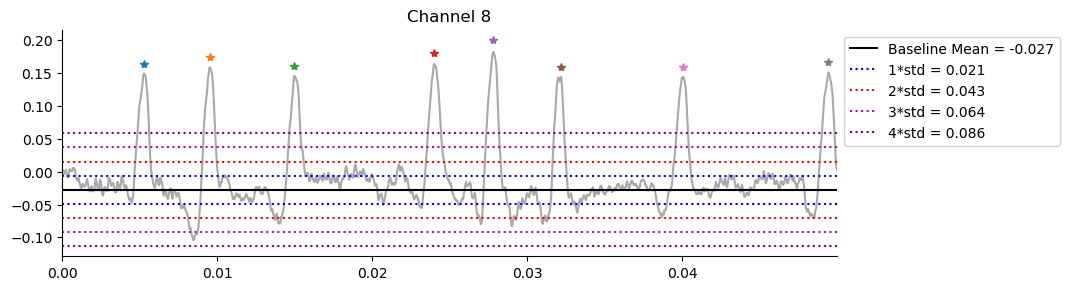

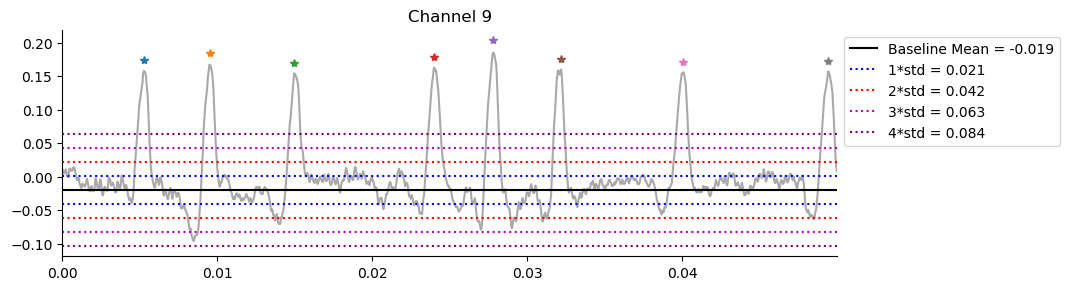

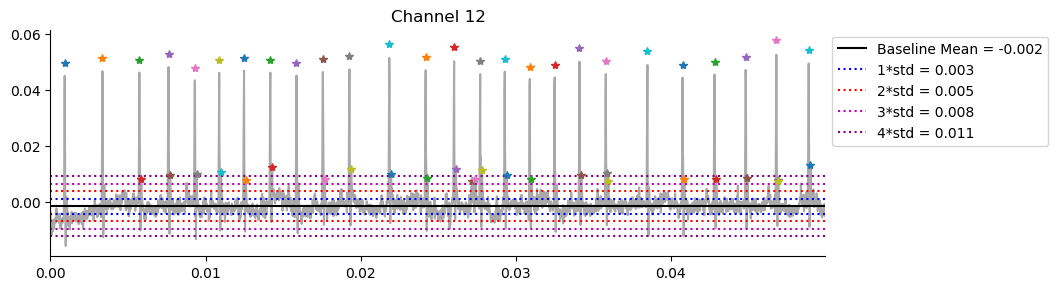

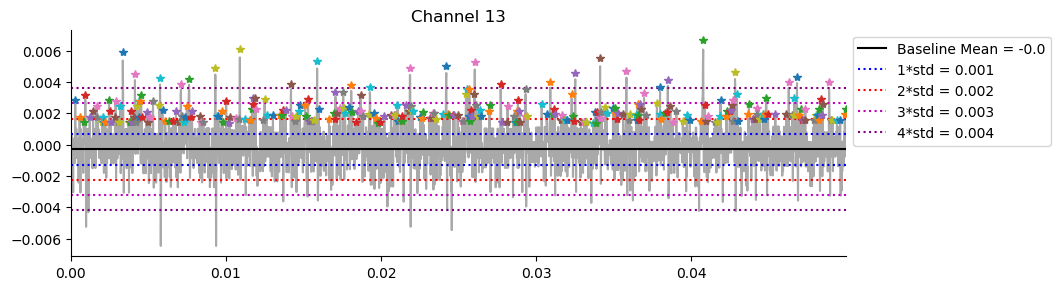

In [14]:
baseline = []
std = []
for signal in amp_signals:
    threshold = 0
    if signal < 13:
        search_result = get_event(template_start_time_dp, template_search_length_dp, 
                                  signal, sigbufs, threshold, ground, True)
        """ search_result = event_peaks_x, event_peaks_y, event_widths, event_half_widths, 
            np.mean(baseline_y), np.std(baseline_y),events
           """
        baseline.append(search_result[4])
        std.append(search_result[5])



### Refine Event Search

* Use the plots above to determine which standard deviation you want to use as your threshold. 
* The higher the standard deviation, the more stringent the event detection rules.
* Potential upgrade: Use event width or half-width to refine templates

In [15]:
thresh8 = 4    # Default = 4
thresh9 = 4    # Default = 4
thresh12 = 8   # Default = 6 Avoids contamination of Q-R peak by P or T

### Tag and measure events

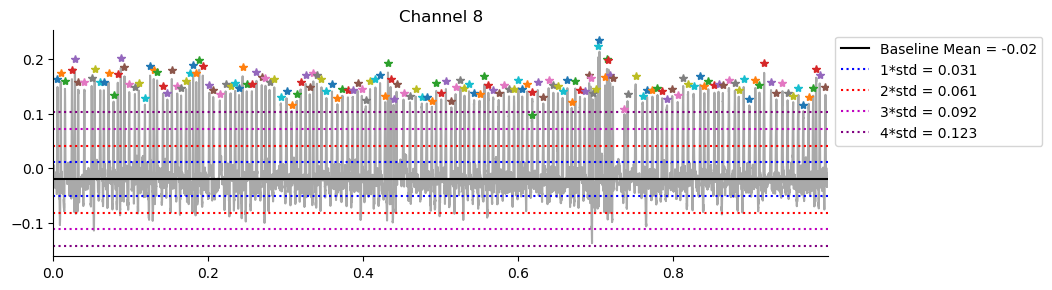

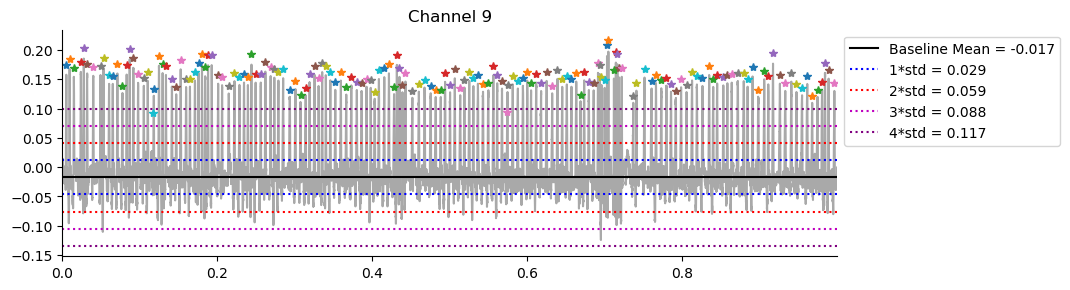

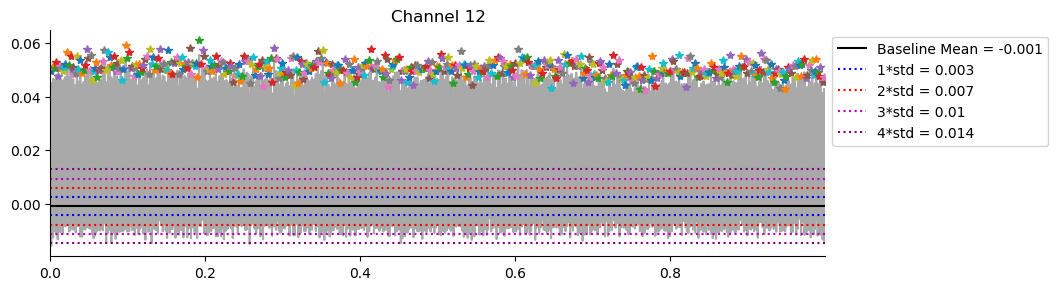

In [16]:
thresholds = [thresh8, thresh9, thresh12]
i = 0
events_list = []
events_xmax = []
events_ymax = []
for threshold in thresholds:
    threshold = std[i] * threshold
    # Default is to search and plot the entire trace
    search_result = get_event (plot_start_time_dp, plot_end_time_dp, amp_signals[i], sigbufs, threshold, baseline[i], True)
    """search_result = event_peaks_x, event_peaks_y, event_widths, event_half_widths, np.mean(baseline_y), 
        np.std(baseline_y),events
           """
    events_list.append(search_result[6])
    events_xmax.append (int(max(search_result[2]))+1)
    events_ymax.append (np.mean(search_result[1]))
    i = i + 1


### Plot events with mean overlayed

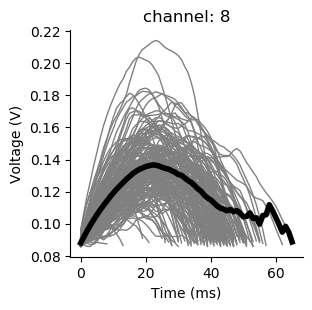

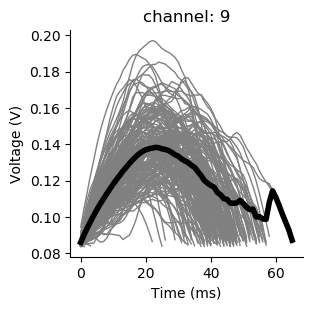

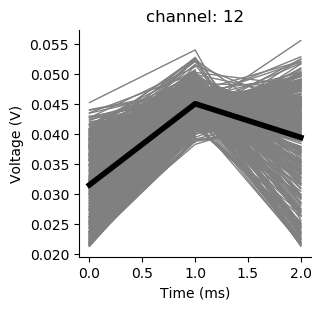

In [17]:
for i in range(len(events_list)):
    plot_events(events_list[i], events_xmax[i], events_ymax[i])

### Find the number of cardiac events following each respiratory event

* Takes the event list and parses it for heartbeats (ECG signal 11/channel 12) relative to breath peaks
* In the background, calculates latency of each heartbeat relative to the most recent breath peak
* Calculates the the width of events relative to the most recent breath peak
* Plots the number of cardiac events relatice to t

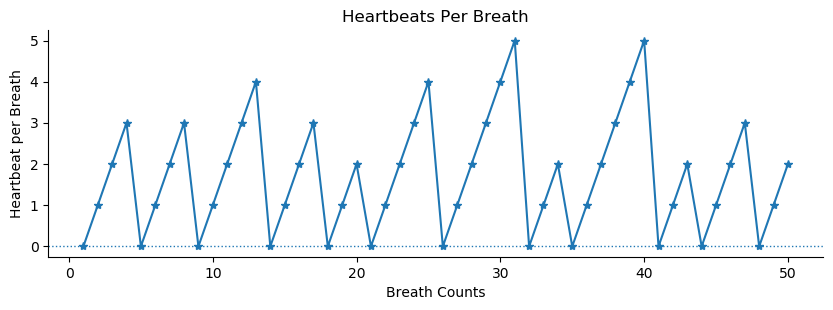

In [23]:
epochs = get_hrv (events_list)
plot_epochs (epochs)        